# Run CellProfiler `illum.cppipe` (IC) pipeline

In this notebook, we run the CellProfiler IC pipeline to calculate the illumination (illum) correction functions for all images per channel (5), apply the functions, and save images into a new directory.

## Import libraries

In [1]:
import argparse
import gc
import glob
import logging
import os
import pathlib
import random
import re
import sys
import time
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

import matplotlib.pyplot as plt

# os.environ["BASIC_DCT_BACKEND"] = "JAX"

os.environ["BASIC_DCT_BACKEND"] = "SCIPY"  # Force BaSiC to CPU, avoids GPU warning
import numpy as np
import psutil
import tifffile
import tqdm

# if does not work
# change the code in basicpy https://github.com/peng-lab/BaSiCPy/issues/159
# line 6 and  37 @_wraps decorator -> implements
from basicpy import BaSiC
from timelapse_utils.file_utils.notebook_init_utils import (
    bandicoot_check,
    init_notebook,
)
from timelapse_utils.image_utils.timelapse_image_utils import t_c_key
from tqdm import tqdm
from tqdm.contrib.concurrent import thread_map

root_dir, in_notebook = init_notebook()

if in_notebook:
    import tqdm.notebook as tqdm
else:
    import tqdm

## Set paths

In [2]:
start_time = time.time()
start_mem = psutil.Process(os.getpid()).memory_info().rss / (
    1024 * 1024 * 1024
)  # in GB

In [3]:
bandicoot_mount_path = pathlib.Path(os.path.expanduser("~/mnt/bandicoot/"))
image_base_dir = bandicoot_check(bandicoot_mount_path, root_dir)

In [4]:
# repository data directory to access the data faster
path_to_processed_data = pathlib.Path(
    f"{image_base_dir}/live_cell_timelapse_pyroptosis_project_data/processed_data/0.renamed_files/"
).resolve()

# save path
path_to_corrected_images = pathlib.Path(
    f"{image_base_dir}/live_cell_timelapse_pyroptosis_project_data/processed_data/1.illumination_corrected_files/"
).resolve()
path_to_corrected_images.mkdir(exist_ok=True, parents=True)

In [5]:
if not in_notebook:
    print("Running as script")
    # set up arg parser
    parser = argparse.ArgumentParser(description="Illumination correction")

    parser.add_argument(
        "--well_fov",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    args = parser.parse_args()
    well_fov = pathlib.Path(args.well_fov).resolve(strict=True)
else:
    print("Running in a notebook")
    well_fov = "B5_1"

input_dir = pathlib.Path(f"{path_to_processed_data}/{well_fov}").resolve(strict=True)

Running in a notebook


## BasicPy functions 
Written by Jenna Tomkinson.
Adapted from: https://github.com/WayScience/NF1_3D_organoid_profiling_pipeline/blob/main/7.technical_analysis/notebooks/test_basicpy.ipynb

In [6]:
def apply_basicpy_correction(
    image_array: np.ndarray,
) -> np.ndarray:
    """Apply BaSiC illumination correction to an image stack or TIFF file.

    Parameters
    --------
    image_array: np.ndarray
        The image stack as a float32 NumPy array.
        Image array should be in the shape (T, Y, X)
        for BaSiC to work properly.

    Returns
    ---------
    np.ndarray
        The BaSiC-corrected image stack as a float32 NumPy array.
    """

    basic = BaSiC(get_darkfield=True)
    basic.fit(image_array)
    corrected = basic.transform(image_array, timelapse=True)

    return corrected

In [7]:
channels_to_process = ["C1", "C2", "C3", "C4", "C5"]
channels_lists = {channel: [] for channel in channels_to_process}
files = list(input_dir.glob("*.tif*"))
files = [str(f) for f in files]
files = sorted(input_dir.glob("*.tif*"), key=t_c_key)

# assign, in order the timelapse files to the correct channel list based on the channel identifier in the filename
for f in files:
    for channel in channels_to_process:
        if channel in f.stem.split("_")[3]:
            channels_lists[channel].append(f)

for channel, file_list in tqdm.tqdm(
    channels_lists.items(), desc="Processing channels", leave=True
):
    channel_time_stack = []
    channel_time_stack = np.stack(
        [
            tifffile.imread(f)
            for f in tqdm.tqdm(
                file_list, desc=f"Processing channel {channel}", leave=False
            )
        ],
        axis=0,
    )
    corrected_channel_time_stack = apply_basicpy_correction(channel_time_stack)
    if np.isnan(corrected_channel_time_stack).any():
        # revert to original time stack if there are any nans in the corrected time stack
        corrected_channel_time_stack = channel_time_stack
    # grab the std of the time stack before correction and after correction and print them out to see if the correction worked
    # switch the dtype back to uint16
    corrected_channel_time_stack = corrected_channel_time_stack.astype(np.uint16)
    # save the corrected time stack as a tiff file in the same directory with the name {well_fov}_{channel}_corrected.tif
    for t, img in tqdm.tqdm(
        enumerate(corrected_channel_time_stack),
        total=len(corrected_channel_time_stack),
        desc=f"Saving corrected channel {channel}",
        leave=False,
    ):
        out_path = (
            path_to_corrected_images
            / f"{well_fov}"
            / f"{well_fov}_T{t+1}_{channel}.tiff"
        )
        out_path.parent.mkdir(exist_ok=True, parents=True)
        # write the image as a tiff file with tifffile
        tifffile.imwrite(
            out_path,
            img,
            imagej=True,
        )

Processing channels:   0%|          | 0/5 [00:00<?, ?it/s]

Processing channel C1:   0%|          | 0/102 [00:00<?, ?it/s]

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Reweighting did not converge.


Saving corrected channel C1:   0%|          | 0/102 [00:00<?, ?it/s]

Processing channel C2:   0%|          | 0/102 [00:00<?, ?it/s]

Saving corrected channel C2:   0%|          | 0/102 [00:00<?, ?it/s]

Processing channel C3:   0%|          | 0/102 [00:00<?, ?it/s]

Reweighting did not converge.
/home/lippincm/miniforge3/envs/timelapse_basicpy_env/lib/python3.10/site-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/lippincm/miniforge3/envs/timelapse_basicpy_env/lib/python3.10/site-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


Saving corrected channel C3:   0%|          | 0/102 [00:00<?, ?it/s]

Processing channel C4:   0%|          | 0/102 [00:00<?, ?it/s]

Reweighting did not converge.


Saving corrected channel C4:   0%|          | 0/102 [00:00<?, ?it/s]

Processing channel C5:   0%|          | 0/102 [00:00<?, ?it/s]

Saving corrected channel C5:   0%|          | 0/102 [00:00<?, ?it/s]

In [8]:
print(f"Total time taken: {(time.time() - start_time)/60:.2f} minutes")
print(
    f"Peak memory usage: {(psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024 * 1024)) - start_mem:.2f} GB"
)

Total time taken: 3.52 minutes
Peak memory usage: 1.73 GB


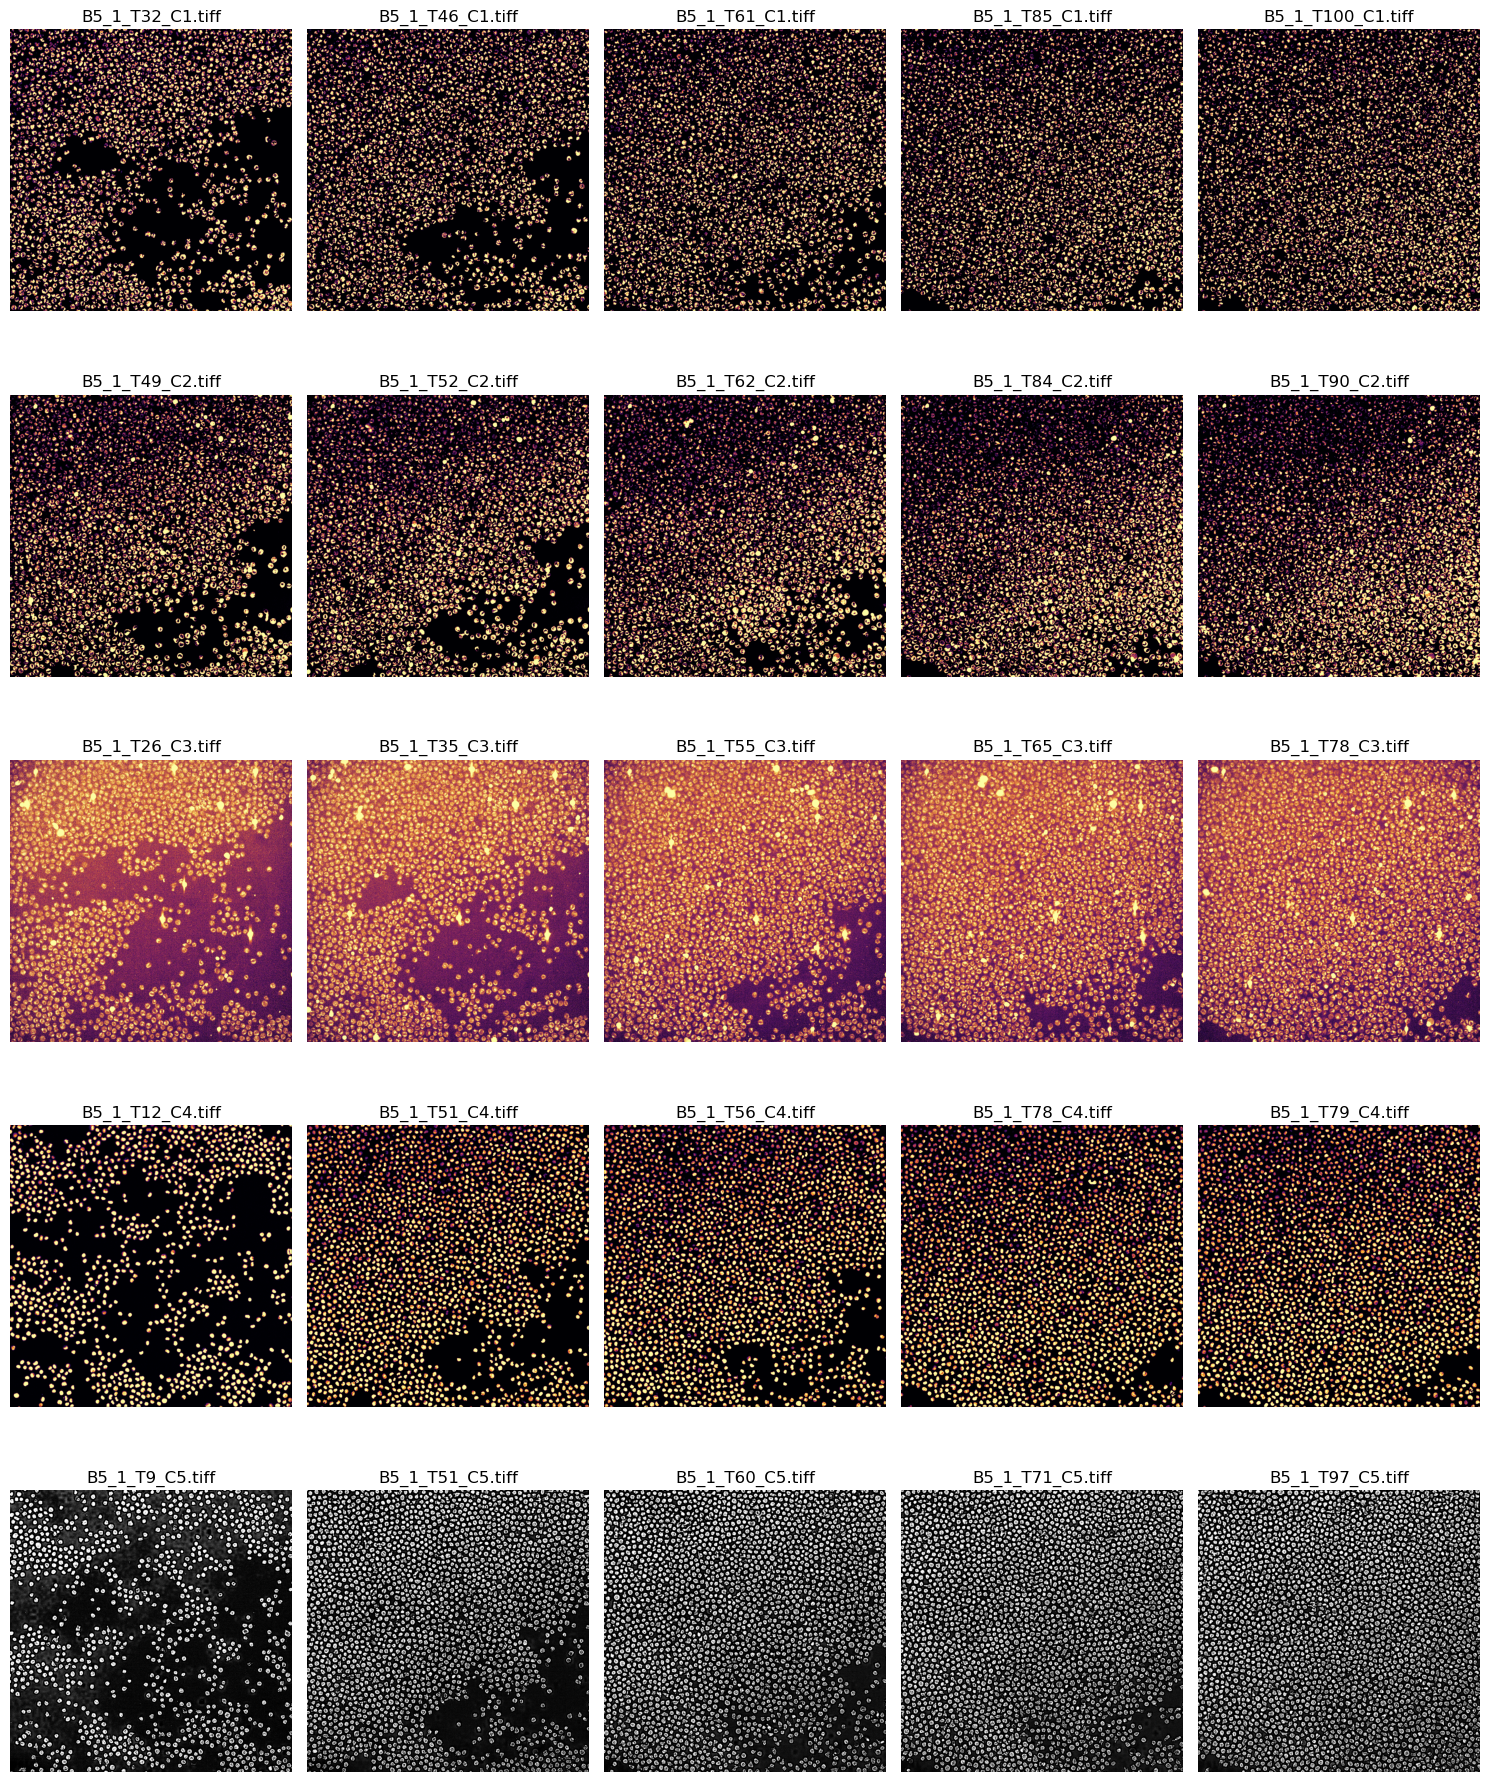

In [9]:
if in_notebook:
    # sanity check show at random 5 timepoint images from the corrected channel time stack
    fig, axes = plt.subplots(5, 5, figsize=(15, 20))
    for i, channel in enumerate(channels_to_process):
        random_paths = random.sample(
            list((path_to_corrected_images / f"{well_fov}").glob(f"*{channel}*.tif*")),
            5,
        )
        # natural sort the random paths
        random_paths = sorted(random_paths, key=t_c_key)
        for j, path in enumerate(random_paths):
            img = tifffile.imread(path)
            # clip limits for better visualization
            img = np.clip(img, 0, np.percentile(img, 90))
            ax = axes[i, j]
            if channel == "C5":
                ax.imshow(img, cmap="gray")
            else:
                ax.imshow(img, cmap="inferno")
            ax.set_title(path.name)
            ax.axis("off")
        plt.tight_layout()
    plt.show()